# Multimodel for SemEval

In [1]:
# 1. Imports & Setup (Same as before)
# -------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [3]:
TRAIN_PATH = "/content/train_chn.csv"
VAL_PATH   = "/content/dev_chn.csv"
TEST_PATH  = "/content/test_chn.csv"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)


In [4]:
# Instead of a single LABEL_VAR, define multiple label columns:
LABEL_COLS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
TEXT_VAR   = "text"

In [5]:
train_df.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,chn_train_track_b_00001,简单说就是有阳性病例，查密切接触者时发现了一些很久没有做核酸的人，还陆续被查出阳性，只能隔离...,0,0,0,0,0,0
1,chn_train_track_b_00002,运镜也好牛 第一次在电视剧中如此密集地感受到 镜头语言 编剧音乐演技都在线,0,0,0,2,0,0
2,chn_train_track_b_00003,现在任何事情只要沾上互联网都会变得不幸。因为脑残太多，总是喜欢毁掉一切美好的事物。,1,0,0,0,0,0
3,chn_train_track_b_00004,如果能在每个黄昏睡醒后 吃到一堆自己喜欢的东西就好了 看着逐渐被黑暗统治的世界 要下一口炸鸡...,0,0,0,2,0,0
4,chn_train_track_b_00005,四五岁时候，我天天在家哭唧唧“我要去上学，为什么不让我去学校”。那时候农村上学晚，也没有太严...,0,0,0,0,0,0


In [6]:
# 3. Load Tokenizer & Model for Embedding Extraction
# -------------------------------------------------------
model_name_1 = "jjlmsy/bert-base-chinese-finetuned-emotion"
model_name_2 = "Johnson8187/Chinese-Emotion-Small"

text_tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1)
text_model_1 = AutoModel.from_pretrained(model_name_1).to(device)

text_tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)
text_model_2 = AutoModel.from_pretrained(model_name_2).to(device)

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

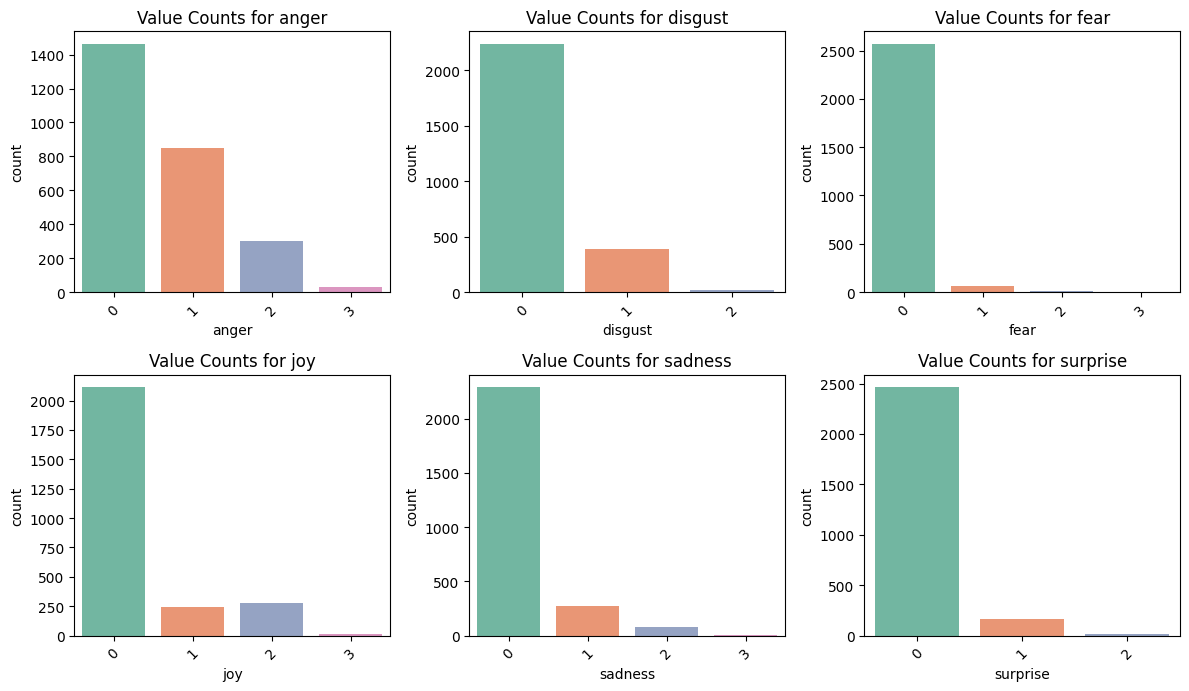

In [7]:
# Set up the plotting area (adjust size as needed)
plt.figure(figsize=(12, 10))

# Plot each categorical column's value counts
# Changed 'few_category_columns' to 'LABEL_COLS'
# Changed 'df' to 'train_df'
for i, col in enumerate(LABEL_COLS):
    plt.subplot(3, 3, i+1)  # Adjust grid size (3x3 here)
    sns.countplot(x=col, data=train_df, palette='Set2')
    plt.title(f'Value Counts for {col}') # Changed title for better clarity
    plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

In [8]:
def extract_multi_model_embeddings(df, save_path,
                                   model1, tokenizer1,
                                   model2, tokenizer2,
                                   max_length=256):
    """Extract embeddings from TWO transformer models, then concatenate."""
    if os.path.exists(save_path):
        print(f"Embeddings already exist at {save_path}")
        return torch.load(save_path)

    embeddings = {}
    model1.eval()
    model2.eval()

    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), desc="Extracting text embeddings", total=len(df)):
            text_sample = row[TEXT_VAR] if isinstance(row[TEXT_VAR], str) else ""

            # Model 1
            inputs_1 = tokenizer1(text_sample, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
            outputs_1 = model1(**inputs_1)
            cls_1 = outputs_1.last_hidden_state[:, 0, :]  # shape: (1, 768)

            # Model 2
            inputs_2 = tokenizer2(text_sample, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
            outputs_2 = model2(**inputs_2)
            cls_2 = outputs_2.last_hidden_state[:, 0, :]  # shape: (1, 768)

            # Concatenate Embeddings
            combined = torch.cat((cls_1, cls_2), dim=1)  # shape: (1, 1536)
            embeddings[idx] = combined.cpu()

    torch.save(embeddings, save_path)
    return embeddings

train_text_embeddings = extract_multi_model_embeddings(train_df, "train_text_embeddings.pt", text_model_1, text_tokenizer_1, text_model_2, text_tokenizer_2)
val_text_embeddings   = extract_multi_model_embeddings(val_df, "val_text_embeddings.pt", text_model_1, text_tokenizer_1, text_model_2, text_tokenizer_2)
test_text_embeddings  = extract_multi_model_embeddings(test_df, "test_text_embeddings.pt", text_model_1, text_tokenizer_1, text_model_2, text_tokenizer_2)

Extracting text embeddings: 100%|██████████| 2642/2642 [01:54<00:00, 22.99it/s]


In [9]:
# 5. Prepare Embeddings (CHANGED for Multi‐Label)
# -------------------------------------------------------
def prepare_text_embeddings(text_embeddings, df, label_cols=None, has_labels=True):
    """For each row in df, gather the text embedding and (optionally) the labels."""
    combined_embeddings = []
    labels = []

    for idx, row in df.iterrows():
        if idx not in text_embeddings:
            continue
        text_embedding = text_embeddings[idx].squeeze()
        combined_embeddings.append(text_embedding)

        if has_labels and label_cols is not None:
            label_vector = row[label_cols].values.astype(int)
            labels.append(label_vector)

    if has_labels and label_cols is not None:
        X = torch.stack(combined_embeddings)
        Y = torch.tensor(labels, dtype=torch.long)
        return X, Y
    else:
        return torch.stack(combined_embeddings)

X_train, y_train = prepare_text_embeddings(train_text_embeddings, train_df, LABEL_COLS, has_labels=True)
X_val, y_val = prepare_text_embeddings(val_text_embeddings, val_df, LABEL_COLS, has_labels=True)
X_test = prepare_text_embeddings(test_text_embeddings, test_df, LABEL_COLS, has_labels=False)


In [10]:
class MLPModel(nn.Module):
    """Multi-Label Multi-Class MLP Model"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.5):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # Output shape: (batch_size, 6 * 4)
        return x.view(-1, 6, 4)  # Reshape to (batch_size, 6, 4)

In [11]:
# Model & Hyperparams
input_dim = 1536  # Combined Transformer Embeddings (768 + 768)
hidden_dim = [1024, 786]
output_dim = 6 * 4  # 6 labels × 4 intensity levels
dropout_p = 0.5
model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)

In [12]:
class MultiLabelMultiClassLoss(nn.Module):
    """Custom loss using CrossEntropyLoss for each label."""
    def __init__(self, num_labels=6, num_classes=4):
        super().__init__()
        self.num_labels = num_labels
        self.num_classes = num_classes
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        batch_size = logits.size(0)
        total_loss = sum(self.ce(logits[:, i, :], targets[:, i]) for i in range(self.num_labels))
        return total_loss / self.num_labels

criterion = MultiLabelMultiClassLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [13]:
# >>> LR DECAY CODE: Define a scheduler after creating optimizer <<<
#>>>from torch.optim.lr_scheduler import ReduceLROnPlateau

#scheduler = ReduceLROnPlateau(
   # optimizer,
  #  mode='min',    # We want to reduce LR if val_loss does not improve
  #  factor=0.5,    # Reduce the LR by half
   # patience=3,    # Number of epochs with no improvement before reducing
   # verbose=True)
# >>> LR DECAY CODE ENDS <<<

In [14]:
# 8. Dataloaders
# -------------------------------------------------------
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test)  # no labels for test

# 8. Dataloaders
# -------------------------------------------------------
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test)  # no labels for test

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(test_dataset,  batch_size=32)

In [15]:
def calculate_metrics(logits_list, labels_list):
    """Calculate macro precision, recall, F1, and accuracy."""
    all_logits = torch.cat(logits_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    N = all_logits.size(0)
    all_logits = all_logits.view(N, 6, 4)
    preds = torch.argmax(all_logits, dim=2)

    preds_flat = preds.view(-1).cpu().numpy()
    labels_flat = all_labels.view(-1).cpu().numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, preds_flat, average="macro", zero_division=0
    )
    accuracy = (preds_flat == labels_flat).mean()

    return accuracy, precision, recall, f1

In [16]:
def train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir):
    best_f1 = -float("inf")
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        logits_list_train, labels_list_train = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            logits_list_train.append(outputs.detach())
            labels_list_train.append(labels.detach())

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(logits_list_train, labels_list_train)
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        logits_list_val, labels_list_val = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                logits_list_val.append(outputs)
                labels_list_val.append(labels)

        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(logits_list_val, labels_list_val)
        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}"
        )

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}_f1_{val_f1:.4f}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f} at epoch {epoch+1}")

    return best_model_path

save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

best_model_path = train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, save_dir=save_dir)

print(f"Best model saved at: {best_model_path}")

Epoch 1/50 Train Loss: 0.5729, Acc: 0.8136, F1: 0.3258 | Val Loss: 0.4119, Acc: 0.8458, F1: 0.3688
Best model saved with F1: 0.3688 at epoch 1
Epoch 2/50 Train Loss: 0.4372, Acc: 0.8434, F1: 0.3793 | Val Loss: 0.3961, Acc: 0.8475, F1: 0.3972
Best model saved with F1: 0.3972 at epoch 2
Epoch 3/50 Train Loss: 0.4188, Acc: 0.8471, F1: 0.4006 | Val Loss: 0.3812, Acc: 0.8517, F1: 0.4045
Best model saved with F1: 0.4045 at epoch 3
Epoch 4/50 Train Loss: 0.4127, Acc: 0.8460, F1: 0.3943 | Val Loss: 0.3821, Acc: 0.8533, F1: 0.4214
Best model saved with F1: 0.4214 at epoch 4
Epoch 5/50 Train Loss: 0.3982, Acc: 0.8542, F1: 0.4174 | Val Loss: 0.3757, Acc: 0.8492, F1: 0.4097
Epoch 6/50 Train Loss: 0.3959, Acc: 0.8540, F1: 0.4233 | Val Loss: 0.3710, Acc: 0.8533, F1: 0.4216
Best model saved with F1: 0.4216 at epoch 6
Epoch 7/50 Train Loss: 0.3902, Acc: 0.8539, F1: 0.4241 | Val Loss: 0.3742, Acc: 0.8500, F1: 0.4197
Epoch 8/50 Train Loss: 0.3862, Acc: 0.8551, F1: 0.4202 | Val Loss: 0.3698, Acc: 0.8483,

In [17]:
def predict_and_generate_submission(test_loader, best_model_path, submission_file_path):
    inference_model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
    inference_model.load_state_dict(torch.load(best_model_path))
    inference_model.eval()

    test_predictions = []
    with torch.no_grad():
        for (inputs,) in test_loader:
            inputs = inputs.to(device)
            outputs = inference_model(inputs)
            batch_size = outputs.size(0)
            outputs = outputs.view(batch_size, 6, 4)
            preds = torch.argmax(outputs, dim=2)
            test_predictions.append(preds.cpu())

    test_predictions = torch.cat(test_predictions, dim=0).numpy()

    submission_df = pd.DataFrame({
        "id": test_df["id"],
        "anger": test_predictions[:, 0],
        "disgust": test_predictions[:, 1],
        "fear": test_predictions[:, 2],
        "joy": test_predictions[:, 3],
        "sadness": test_predictions[:, 4],
        "surprise": test_predictions[:, 5]
    })

    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")
    return submission_df

submission_file_path = "submission.csv"
submission_df = predict_and_generate_submission(test_loader, best_model_path, submission_file_path)
submission_df.head()

Submission file saved to submission.csv


,id,anger,disgust,fear,joy,sadness,surprise
0,chn_test_track_b_00001,1,0,0,0,0,1
1,chn_test_track_b_00002,0,0,0,0,0,0
2,chn_test_track_b_00003,0,0,0,0,1,0
3,chn_test_track_b_00004,0,0,0,0,0,0
4,chn_test_track_b_00005,0,0,0,0,0,0


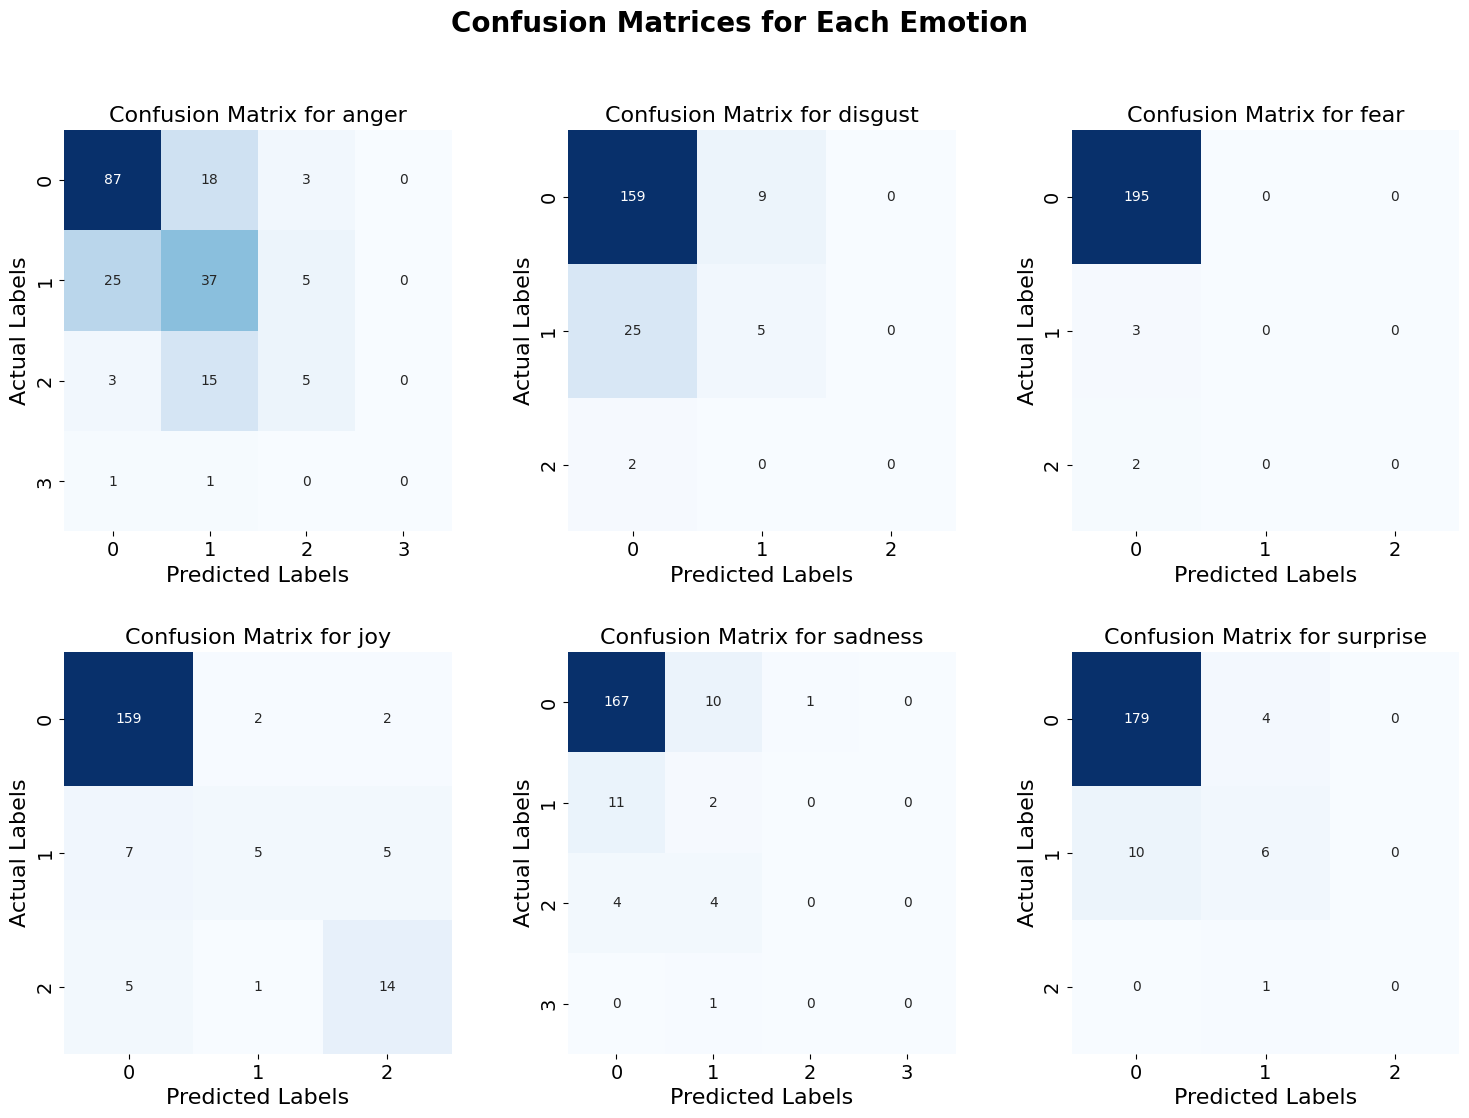

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(model, data_loader, label_names, num_classes=4):
    """Plots 6 confusion matrices (one per emotion) in a single figure with large font size."""

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_size = outputs.size(0)
            outputs = outputs.view(batch_size, 6, num_classes)
            preds = torch.argmax(outputs, dim=2)  # Get class predictions

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
    plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between plots

    for i, ax in enumerate(axes.flat):
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)

        ax.set_title(f'Confusion Matrix for {label_names[i]}', fontsize=16)  # Title
        ax.set_xlabel("Predicted Labels", fontsize=16)  # X-axis label
        ax.set_ylabel("Actual Labels", fontsize=16)  # Y-axis label
        ax.tick_params(axis="both", labelsize=14)  # Set font size for tick labels

    plt.suptitle("Confusion Matrices for Each Emotion", fontsize=20, fontweight="bold")
    plt.show()

# Call the function
plot_confusion_matrices(model, val_loader, LABEL_COLS, num_classes=4)


In [23]:
def show_predictions(model, data_loader, label_names, num_examples=5):
    """Displays some right and wrong predictions with actual labels."""

    model.eval()
    correct_preds = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_size = outputs.size(0)
            outputs = outputs.view(batch_size, 6, 4)
            preds = torch.argmax(outputs, dim=2)  # Get predicted labels

            for i in range(batch_size):
                text_sample = val_df.iloc[i][TEXT_VAR]  # Get corresponding text
                actual = labels[i].cpu().numpy()
                predicted = preds[i].cpu().numpy()

                if np.array_equal(actual, predicted):
                    correct_preds.append((text_sample, actual, predicted))
                else:
                    incorrect_preds.append((text_sample, actual, predicted))

            if len(correct_preds) >= num_examples and len(incorrect_preds) >= num_examples:
                break  # Stop when we have enough examples

    # Print correct predictions
    print("\n✅ Correct Predictions:")
    for i, (text, actual, predicted) in enumerate(correct_preds[:num_examples]):
        print(f"\nExample {i+1}:")
        print(f"Text: {text}")
        print(f"Actual Labels: {actual}")
        print(f"Predicted Labels: {predicted}")

    # Print incorrect predictions
    print("\n❌ Incorrect Predictions:")
    for i, (text, actual, predicted) in enumerate(incorrect_preds[:num_examples]):
        print(f"\nExample {i+1}:")
        print(f"Text: {text}")
        print(f"Actual Labels: {actual}")
        print(f"Predicted Labels: {predicted}")

# Call the function to print some right and wrong predictions
show_predictions(model, val_loader, LABEL_COLS, num_examples=5)




✅ Correct Predictions:

Example 1:
Text: （不管你姓江还姓刘，只要是中国法律管的人！）个人募捐这个事，就该摆上台面！希望今后，再不必看这永无止境，子子孙孙无穷尽的个人募捐！
Actual Labels: [2 0 0 0 0 0]
Predicted Labels: [2 0 0 0 0 0]

Example 2:
Text: 我相信你，我在海珠区凤阳街道，我的邻居遭遇了和你一样的事情，通知阳性，显示检测中，然后下午来人拉走了。
Actual Labels: [1 0 0 0 0 0]
Predicted Labels: [1 0 0 0 0 0]

Example 3:
Text: 人生的每一场相遇，都是缘分，没有对错。人生的每一个清晨，都该努力，不能拖。
Actual Labels: [0 0 0 1 0 0]
Predicted Labels: [0 0 0 1 0 0]

Example 4:
Text: 现实生活中确实是这样，坏人被抓被判，好人继续过着自己的生活，平平淡淡，也不需要过度夸大。
Actual Labels: [0 0 0 0 0 0]
Predicted Labels: [0 0 0 0 0 0]

Example 5:
Text: 没有高启强不是还有陈泰、徐江…这是一类人的存在，安欣面对的不是高启强，而是高启强们和他们背后的保护伞～所以他的结局从一开始就注定了悲壮
Actual Labels: [0 0 0 0 0 0]
Predicted Labels: [0 0 0 0 0 0]

❌ Incorrect Predictions:

Example 1:
Text: 害，人家看不见张嘴还是💊王，也不知道从哪拿的钱，最近手头儿紧我也想挣点。
Actual Labels: [0 0 0 0 0 0]
Predicted Labels: [0 0 0 0 1 0]

Example 2:
Text: ＂秋收冬藏，鸟语花香，你是来日方长.＂
Actual Labels: [0 0 0 1 0 0]
Predicted Labels: [0 0 0 2 0 0]

Example 3:
Text: 过家家，摘野花刺泡野草莓茶籽茶叶花生等，收油菜籽稻谷，在田里拿禾堆堆稻草屋，坐桥上用脚捞上游来的水藻，枣等